# The effect of a Universal Child Benefit - González (2013) Revisited

## A Project by Antonia Entorf & Marc Lipfert

### Overview

This notebook replicates the main results presented in the following article:   

González, L. (2013): [The Effect of a Universal Child Benefit on Conceptions, Abortions, and Early Maternal Labor Supply](https://www.aeaweb.org/articles?id=10.1257/pol.5.3.160). American Economic Journal: Economic Policy 5(3): 160–188.

In that paper, the author investigates the effect of a universal child benefit on fertility, household expenditure patterns and maternal labor supply. In particular, she is able to exploit the unanticipated introduction of a child benefit that took place in Spain in 2007 by utilising a Regression Discontinuity Design.

Apart from replicating major findings presented by González, our aim is to enrich her analysis with respect to three different aspects. First, we will examine whether accounting for autocorrelation is necessary in the given context. Secondly, since the benefit was suspended in the aftermath of the financial crisis, we will exploit this fact and apply the identical research design to the abolishment of the policy in order to study the effect on conceptions. Thirdly, we will investigate threats to validity using simulations as well as a placebo test.




### Introduction

On July 3 in 2007, the Spanish government announced the introduction of a universal child benefit. Mothers giving birth from July 1, 2007 onwards were eligible to receive a one-time cash payment of 2,500€. Libertad González, henceforth LG, analyzes the effect of this child benefit on the number of conceptions and abortions as well as on household expenditures, maternal labor supply and day care use. She uses a sharp regression discontinuity design (RDD) for her analysis, where the running variable is time and the treatment variable is equal to 1 after July 1 2007 and zero before that date.

A problem which could occur when using a RDD is self selection into treatment. In this particular setting one could imagine that women try to postpone birth in order to give birth after the cutoff date and not before. This scenario seems especially plausible for low income families who are in greater need of the cash payment. Therefore, the mothers giving birth right before and rigth after the cutoff could differ in personal characteristics, such as income and education. This could lead to a bias in the estimated average treatment effect if low income families react differently to receiving treatment compared to high income families and, additionally, we are not able to control for these personal characteristics.

However, self slection into treatment was not possible in our setting, because the introduction of the policy was unexpected and the announcement was even two days after the actual cutoff date. These two aspects rule out the possiblity to postpone birth in order to receive the benefit.

In the following, we will explain the research question in more detail using causal graphs.

#### Effect on Fertility

<img src="causal-graphs/causal-graph-fertility.png" height="600" />

The causal graph above represents two regression analyses. First, LG is interested in the effect of the introduction of the child benefit on the number of conceptions per month and, second, on the number of abortions per month. Thus, the treatment variable is the introduction of the child benefit and the dependent variables are number of conceptions and number of abortions per month. In this graph the treatment should be interpreted as having the possibility to get the benefit and not as already having the benefit.

The running variable, time, determines assignment to treatment and, furthermore, influences conceptions and abortions through seasonality effects. The treatment variable is supposed to influence conceptions and abortions, which both determine the number of births. Observable and unobservable personal characteristics influence conceptions, abortions, and births. The reason why we draw a path from personal characteristics to births in addition to the paths to conceptions and abortions is that women with specific personal or biological coditions are more likely to giving birth successfully.

One could expect that the number of conceptions increases after the introduction because the promise of receiving a cash payment increases families' incentives to get a child. The same reasoning can be applied to the number of abortions. Treated women have more incentives to reject an abortion than untreated women. Therefore, the introduction of the benefit should reduce the number of abortions.

Obviously, 2,500€ is rather few compared to the costs associated with a child. Thus, a pontential impact of the treatment on the variables of interest should be small.

*We could think about whether rather low educated families aim for the cash payment not only due to probably lower income but also because they underestimate the costs associated with a child!*

Important is that we actually do not observe the number of *conceptions* per month but only the number of *births* per month. LG's idea was then to calculate the month of conception based on the month of birth by subtracting the approximate number of months a woman was pregnant.

However, birth is a collider variable mutually depending on conceptions and abortions. Thus, when calculating conception while ignoring abortion our results might not be accurate. To illustrate this, imagine that the treatment does not at all affect the number of conceptions. However, at the same time many treated women who are already pregnant decide to not having an abortion while their untreated counterfactual would have decided to have an abortion. Thus, the treatment causes a reduction in the number of abortions which, clearly, leads to an increase in the number of births. If we then calculate conceptions based on births it would look like an increase in the number of conceptions, although it was unchanged. Therefore, we must bear in mind that a change in the conception variable can be partly driven by a change in the abortion variable.

#### Effect on Economic Variables

<img src="causal-graphs/causal-graph-economic-variables.png" height="600" />

### Replication
Before we can start with the data analysis we need to prepare the data sets. Therefore we translate the author's Stata code into python code. There are three different do-files using different datasets.

In the following I will translate the births do-file which you can find in "Additional Materials" on the AEJ-website.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.formula.api as sm
import statsmodels.tsa.api as smt
#from patsy import dmatrices
import matplotlib.pyplot as plt

#### Conceptions

In [2]:
df_births = pd.read_stata('data/data_births_20110196.dta')
df_births.head()

,mesp,year,prem,semanas
0,3.0,2000.0,1,0.0
1,1.0,2000.0,2,36.0
2,3.0,2000.0,1,37.0
3,3.0,2000.0,1,39.0
4,12.0,2000.0,1,0.0


#### Variables
mesp: Month of birth <br>
year: Year of birth <br>
prem: Prematurity indicator (1 if baby is not premature, 2 if it is) <br>
semanas: Number of weeks of gestation at birth

In [3]:
df_births.describe().round(2)

,mesp,year,prem,semanas
count,4984066.00,4984066.00,4984066.00,4706361.00
mean,6.57,2041.50,1.07,34.93
std,3.44,35.83,0.26,11.71
min,1.00,2000.00,1.00,0.00
25%,4.00,2003.00,1.00,38.00
50%,7.00,2005.00,1.00,39.00
75%,10.00,2008.00,1.00,40.00
max,12.00,2010.00,2.00,46.00


Create month of birth variable based on month of policy intervention in July 2007. Month of intervention is set equal to zero, the next month = 1, the previos month = -1, and so on.

In [4]:
df_births['m'] = 500
# we have data for 10 years
for i in range(11):
    df_births.loc[df_births['year'] == 2000 + i,'m'] = df_births['mesp'] - 91 + 12*i
# check that no 500 is left
sum(df_births['m'] == 500)

0

We can check that in 2007 the smalles number is -6 which is for Janurary and the largest is 5 which is for December:

In [5]:
min(df_births.loc[df_births['year'] == 2007,'m']), max(df_births.loc[df_births['year'] == 2007,'m'])

(-6.0, 5.0)

In [6]:
df_births['m'].describe().round(2)

count    4984066.00
mean         -21.56
std           37.63
min          -90.00
25%          -53.00
50%          -20.00
75%           11.00
max           41.00
Name: m, dtype: float64

#### Create month of conception variable
We are not interested in the month of birth but in the month of conception. Therefore we subtract e.g. 9 months from the month of birth to get month of conception.

1.) the naive definition: 9 months before birth

In [7]:
df_births['mc1'] = df_births['m'] - 9

2.) naive plus prematures *(I don't know yet why my numbers here are all equal to 1, although this one here is 2 and the next 3 in my local notebook)*

In [8]:
# share of premature babys
sum(df_births['prem'] == 2)/len(df_births['prem'])

0.07037145976798863

In [9]:
max(df_births.loc[df_births['prem'] == 2, 'semanas'])

36.0

In [10]:
# generating mc2
df_births['mc2'] = np.where((df_births['prem'] == 2) |
        # if premature baby subtract only 8 months to get month of conception
        ((0 < df_births['semanas']) & (df_births['semanas'] < 38)), df_births['m'] - 8,
        # otherwise subtract 9
        df_births['m'] - 9)
#why 38 and not 39 as in the sophisticated version???

3.) sophisticated

In [11]:
sum(df_births['semanas'] == 0)/len(df_births['semanas'])
# why is semanas zero for some obs?

0.09286253432438495

In [12]:
# generating mc3
df_births['mc3'] = np.where((df_births['prem'] == 2) |
        # if premature baby subtract only 8 months to get month of conception
        ((0 < df_births['semanas']) & (df_births['semanas'] < 39)), df_births['m'] - 8,
        # otherwise if baby was born only after 43 months --> -10
        np.where(df_births['semanas'] > 43, df_births['m'] - 10,
        # otherwise  - 9
        df_births['m'] - 9))

In [13]:
df_births[['semanas','mc1', 'mc2', 'mc3']].head()

,semanas,mc1,mc2,mc3
0,0.0,-97.0,-97.0,-97.0
1,36.0,-99.0,-98.0,-98.0
2,37.0,-97.0,-96.0,-96.0
3,39.0,-97.0,-97.0,-97.0
4,0.0,-88.0,-88.0,-88.0


What about observations with semanas = 0? <br>
I would drop all observations with semanas = 0. Furthermore, I would calculate the month of conception with even higher precision by applying the same reasoning as used for semanas < 39 for semanas < 35

#### Group Data
Only the sophisticated version of month of conception (mc3) is used for the analysis. <br>
Now, I will group the data by mc3 and count the number of observations per month.

In [14]:
# rename
df_births['mc'] = df_births['mc3']
# this variable will indicate the number of conceiption per month:
df_births['n'] = 1
dfb = df_births.groupby('mc', as_index = False)['n'].count()

dfb.head()

,mc,n
0,-100.0,6
1,-99.0,24690
2,-98.0,30595
3,-97.0,32547
4,-96.0,32352


In [15]:
dfb.tail()

,mc,n
129,29.0,41709
130,30.0,42480
131,31.0,41202
132,32.0,41703
133,33.0,11322


generate calendar month of conception

The author made some mistakes here!

In [16]:
dfb['month'] = 0

#note that range starts at 0 but does not include the last number
for i in range(3):
    dfb.loc[dfb['mc'] == 0 + 12*i, 'month'] = 7
    dfb.loc[dfb['mc'] == 1 + 12*i, 'month'] = 8
    dfb.loc[dfb['mc'] == 2 + 12*i, 'month'] = 9
    dfb.loc[dfb['mc'] == 3 + 12*i, 'month'] = 10
    dfb.loc[dfb['mc'] == 4 + 12*i, 'month'] = 11
    dfb.loc[dfb['mc'] == 5 + 12*i, 'month'] = 12
    dfb.loc[dfb['mc'] == 6 + 12*i, 'month'] = 1
    dfb.loc[dfb['mc'] == 7 + 12*i, 'month'] = 2
    dfb.loc[dfb['mc'] == 8 + 12*i, 'month'] = 3
    dfb.loc[dfb['mc'] == 9 + 12*i, 'month'] = 4
    dfb.loc[dfb['mc'] == 10 + 12*i, 'month'] = 5
    dfb.loc[dfb['mc'] == 11 + 12*i, 'month'] = 6
       
for i in range(9):
    dfb.loc[dfb['mc'] == -1 - 12*i, 'month'] = 6
    dfb.loc[dfb['mc'] == -2 - 12*i, 'month'] = 5
    dfb.loc[dfb['mc'] == -3 - 12*i, 'month'] = 4
    dfb.loc[dfb['mc'] == -4 - 12*i, 'month'] = 3
    dfb.loc[dfb['mc'] == -5 - 12*i, 'month'] = 2
    dfb.loc[dfb['mc'] == -6 - 12*i, 'month'] = 1
    dfb.loc[dfb['mc'] == -7 - 12*i, 'month'] = 12
    dfb.loc[dfb['mc'] == -8 - 12*i, 'month'] = 11
    dfb.loc[dfb['mc'] == -9 - 12*i, 'month'] = 10
    dfb.loc[dfb['mc'] == -10 - 12*i, 'month'] = 9
    dfb.loc[dfb['mc'] == -11 - 12*i, 'month'] = 8
    dfb.loc[dfb['mc'] == -12 - 12*i, 'month'] = 7

# check that no zero is left
sum(dfb['month'] == 0)

0

In [17]:
# generate July indicator
dfb['july'] = np.where(dfb['month'] == 7, 1, 0)

generate number of days in a month <br>
Note that from 2000 - 2010 there are the following leap years: 2008, 2004, 2000. This is relevant for mc = 7, 7-12 times 4, 7-12 times 8 <br>
For some reason the author only adjusted feburary in 2008.

In [18]:
dfb['days'] = np.where((dfb['mc'] == 7) | (dfb['mc'] == -41) |
        (dfb['mc'] == -89), 29,
        # for all other feburarys
        np.where(dfb['month'] == 2, 28,
        # for April, June, September, November
        np.where((dfb['month'] == 4) | (dfb['month'] == 6) |
                (dfb['month'] == 9) | (dfb['month'] == 11), 30, 31)))



# indicator for treatment group (post-policy conception), i.e. after June 2007
dfb['post'] = np.where(dfb['mc'] >= 0, 1, 0)


# quadratic and cubic mc
dfb['mc2'] = dfb['mc']*dfb['mc']
dfb['mc3'] = dfb['mc']*dfb['mc']*dfb['mc']

# natural log of number of obs n
dfb['ln'] = np.log(dfb['n'])

# get month dummies
dummies = pd.get_dummies(dfb['month'])
dummies.columns = ['jan','feb','mar','apr','mai','jun','jul','aug','sep','oct','nov','dec']
# bind data frames
dfb = pd.concat([dfb, dummies], axis=1)

The following is part of the paper's Descriptive Statitics in Table 1

In [19]:
dfb.loc[(dfb['mc']>-91) & (dfb['mc']<30), ['n','ln','post','mc','month','days']].describe().round(2)

,n,ln,post,mc,month,days
count,120.00,120.00,120.00,120.00,120.00,120.00
mean,38020.64,10.54,0.25,-30.50,6.50,30.44
std,3167.55,0.08,0.43,34.79,3.47,0.81
min,30138.00,10.31,0.00,-90.00,1.00,28.00
25%,35775.25,10.49,0.00,-60.25,3.75,30.00
50%,38505.00,10.56,0.00,-30.50,6.50,31.00
75%,40305.75,10.60,0.25,-0.75,9.25,31.00
max,44375.00,10.70,1.00,29.00,12.00,31.00


### Plotting monthly conceptions

In [20]:
# generating year variable

dfb['year'] = np.nan

x = 0
while x < 12:
    dfb.loc[dfb['mc'] < 42 -(x*12), 'year'] = (2010 - x)
    x += 1

dfb.sort_values(by=['mc'], inplace=True)
dfb[['year','month','n']].head()

,year,month,n
0,1999.0,3,6
1,1999.0,4,24690
2,1999.0,5,30595
3,1999.0,6,32547
4,1999.0,7,32352


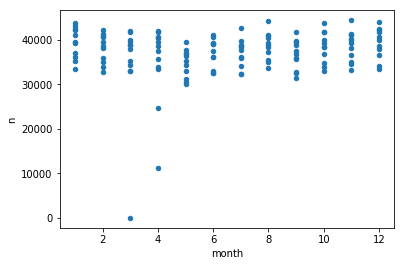

In [21]:
dfb.plot(x='month',y='n',kind="scatter")

In [22]:
# 3 outliers:
dfb.loc[dfb['n']<28000,['year','month','mc','n']]

,year,month,mc,n
0,1999.0,3,-100.0,6
1,1999.0,4,-99.0,24690
133,2010.0,4,33.0,11322


Think about outliers again....

In [23]:
# collecting mean values per month

month = {'month':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
df_mean = pd.DataFrame(data=month)

df_mean['mean'] = np.nan

x=1
while x < 13:
    df_mean.loc[df_mean['month'] == x, 'mean'] = dfb.loc[(dfb['month']==x) & (dfb['n']>28000),'n'].mean()
    x += 1

df_mean

,month,mean
0,1,39399.727273
1,2,38041.000000
2,3,37667.000000
3,4,38290.800000
4,5,34733.090909
5,6,37002.272727
6,7,36967.909091
7,8,38550.818182
8,9,36581.545455
9,10,38334.272727


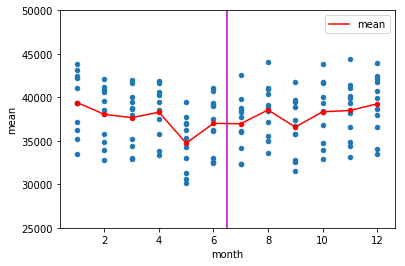

In [24]:
# Plotting scatter with mean

ax=dfb.plot(x='month',y='n',kind="scatter",ylim=(25000,50000))
ax1=df_mean.plot(x='month',y='mean',kind="line", color="r", ax=ax)
df_mean.plot(x='month',y='mean',kind="scatter", color="r", ax=ax1)
plt.axvline(x=6.5, color="m")
plt.show()

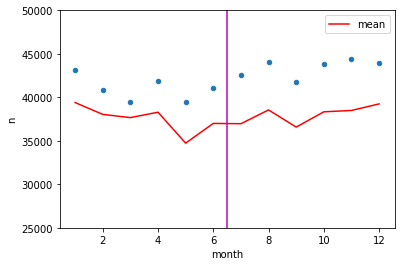

In [25]:
# Plotting 2007 vs. mean 

ax1=dfb.loc[dfb['year']==2007,['month','n']].plot(x='month',y='n',kind="scatter",ylim=(25000,50000))
df_mean.plot(x='month',y='mean',kind="line", color="r", ax=ax1)
plt.axvline(x=6.5, color="m")
plt.show()

### Regressions
The author uses different subsets of the data and slightly different specifications.

In [26]:
# create necessary subsets of dfb
dfb_list = list()

dfb_list.append(dfb.loc[(dfb['mc']>-91) & (dfb['mc']<30)])
dfb_list.append(dfb.loc[(dfb['mc']>-31) & (dfb['mc']<30)]) # 5 years
dfb_list.append(dfb.loc[(dfb['mc']>-13) & (dfb['mc']<12)]) # 12 months
dfb_list.append(dfb.loc[(dfb['mc']>-10) & (dfb['mc']<9)]) # 9 months
dfb_list.append(dfb.loc[(dfb['mc']>-4) & (dfb['mc']<3)]) # 3 months
dfb_list.append(dfb.loc[(dfb['mc']>-67) & (dfb['mc']<30)]) # 8 year

# run regressions
reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + mc3 + post*mc3 + days', data=dfb_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days', data=dfb_list[1]).fit(cov_type='HC1')
reg3 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days', data=dfb_list[2]).fit(cov_type='HC1')
reg4 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=dfb_list[3]).fit(cov_type='HC1')
reg5 = smf.ols(formula =
        'ln ~ post + days', data=dfb_list[4]).fit(cov_type='HC1')
reg6 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + mc3 + post*mc3 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfb_list[0]).fit(cov_type='HC1')
reg7 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfb_list[5]).fit(cov_type='HC1')
reg8 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfb_list[1]).fit(cov_type='HC1')

# store regessions in list
reg_list_b = [reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8]

First Part of Table 2 - Fertility Results (Conceptions and Abortions)

In [27]:
# Make a table equivalent to Table 2 with coefficients and se for post variable
print('\u2014'*110)
print('{:<12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'
      .format("", "RDD (1)", "RDD (2)", "RDD (3)", "RDD (4)", "RDD (5)", "DID (6)", "DID (7)", "DID (8)"))
print('{:<12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'
      .format("", "10 years", "5 years", "12 months", "9 months", "3 months", "10 years", "7 years", "5 years"))
print('\u2014'*110)
print('{:<12s}'.format("Conceptions"), end="")
for i in range(len(reg_list_b)):
    print ('{:>12.4f}'.format(reg_list_b[i].params.post), end="")
print(" "*110)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_b)):
    print ('{:>12.4f}'.format(reg_list_b[j].bse.post), end="")

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
                 RDD (1)     RDD (2)     RDD (3)     RDD (4)     RDD (5)     DID (6)     DID (7)     DID (8)
                10 years     5 years   12 months    9 months    3 months    10 years     7 years     5 years
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Conceptions       0.0531      0.0695      0.0852      0.0750      0.0503      0.0495      0.0539      0.0527                                                                                                              
                  0.0219      0.0250      0.0359      0.0285      0.0314      0.0103      0.0088      0.0136

We can observe small differences with respect to the 7 and 10 year specifications because because now we take into account all leap years during those time periods.

#### Autocorrelation Plots

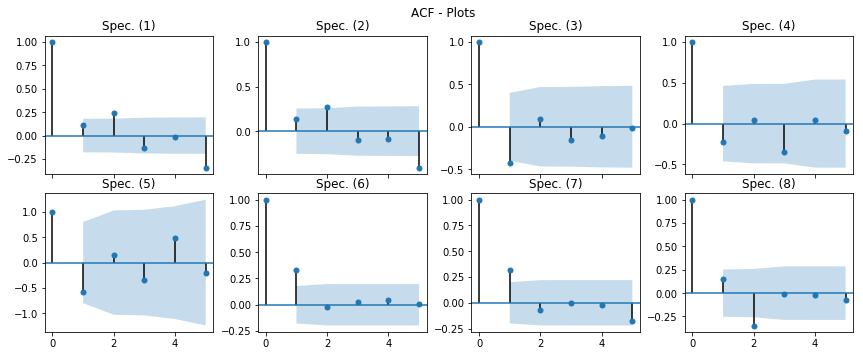

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=True, figsize=(12,5))


plt.tight_layout()
fig.suptitle('ACF - Plots')
plt.subplots_adjust(top=0.9)

for x in range(4):
    smt.graphics.plot_acf(reg_list_b[x].resid,lags=5,alpha=0.05, ax=axes[0,x])
    axes[0,x].set_title('Spec. ('+str(x+1)+')')
    smt.graphics.plot_acf(reg_list_b[x+4].resid,lags=5,alpha=0.05, ax=axes[1,x])
    axes[1,x].set_title('Spec. ('+str(x+5)+')')



Accounting for Autocorrelation appears to be necessary at least in some specifications...

#### Abortions

In [29]:
dfa = pd.read_stata('data/data_abortions_20110196.dta')
dfa.describe().round(2)

,year,month,n_ive_and,n_ive_val,n_ive_rioja,n_ive_cat,n_ive_can,n_ive_mad,n_ive_gal,n_ive_bal,n_ive_pv,n_ive_castlm,n_ive_ast,n_ive_arag
count,144.00,144.00,132.00,132.00,120.00,120.00,144.00,120.00,120.00,120.00,120.00,132.00,132.00,132.00
mean,2004.50,6.50,1304.08,769.14,40.45,1520.87,303.17,1415.85,215.08,212.16,190.10,251.08,177.80,286.87
std,3.46,3.46,350.94,173.65,9.08,372.71,84.05,326.50,29.13,33.21,48.82,23.85,25.58,44.14
min,1999.00,1.00,694.00,430.00,21.00,957.00,161.00,820.00,159.00,146.00,105.00,198.00,117.00,175.00
25%,2001.75,3.75,1006.50,634.75,34.00,1207.50,236.00,1192.00,196.00,189.00,147.00,234.75,158.00,265.75
50%,2004.50,6.50,1313.50,772.00,40.00,1411.00,269.50,1383.00,211.50,211.00,184.50,252.00,178.00,287.00
75%,2007.25,9.25,1580.50,898.25,46.25,1801.00,374.25,1647.50,228.00,235.25,236.25,264.25,196.00,317.00
max,2010.00,12.00,2021.00,1144.00,67.00,2442.00,483.00,2113.00,341.00,295.00,283.00,315.00,241.00,398.00


The variables starting with "n_ive_" are the number of abortions per month in different regions of Spain. For some regions we have observations for 1999-2009 and for others from 2000-2010.

The following manipulations are comparable to those for the births data set.

In [30]:
# sum of abortions across all regions
# 2:14 chooses columns 3 to 14
dfa['n_tot'] = dfa.iloc[:,2:14].sum(axis=1)

# month variable that takes value 0 in July 2007:
# the data is already sorted and there is only one observations per month and
# year.
dfa['m'] = range(len(dfa))
# find value for July 2007:
dfa.loc[(dfa['year'] == 2007) & (dfa['month'] == 7), 'm'] # 102
dfa['m'] = dfa['m'] - 102

# days in a month:
dfa['days'] = np.where((dfa['month'] == 2) & ((dfa['year'] == 2000) | (dfa['year'] == 2004) | (dfa['year'] == 2008)), 29,
        # for all other feburarys
        np.where(dfa['month'] == 2, 28,
        # for April, June, September, November
        np.where((dfa['month'] == 4) | (dfa['month'] == 6) |
                (dfa['month'] == 9) | (dfa['month'] == 11), 30,
        # otherwise
        31)))

# log-abortions
dfa['log_ive'] = np.log(dfa['n_tot'])

# squared and cubed terms
dfa['m2'] = dfa['m']*dfa['m']
dfa['m3'] = dfa['m']*dfa['m']*dfa['m']

# post indicator
dfa['post'] = np.where(dfa['m'] >= 0, 1, 0)

# restrict period
dfa = dfa.loc[(dfa['m']> -91) & (dfa['m']<30)]

# get month dummies
dummies = pd.get_dummies(dfa['month'])
dummies.columns = ['jan','feb','mar','apr','mai','jun','jul','aug','sep','oct','nov','dec']
# bind data frames
dfa = pd.concat([dfa, dummies], axis=1)

The following is part of the paper's Table 1 - Descriptive Statitics

In [31]:
dfa[['n_tot','log_ive','post','m','month','days']].describe().round(2)

,n_tot,log_ive,post,m,month,days
count,120.00,120.00,120.00,120.00,120.00,120.00
mean,6724.62,8.79,0.25,-30.50,6.50,30.44
std,1348.07,0.20,0.43,34.79,3.47,0.81
min,4512.00,8.41,0.00,-90.00,1.00,28.00
25%,5624.00,8.63,0.00,-60.25,3.75,30.00
50%,6535.50,8.79,0.00,-30.50,6.50,31.00
75%,7710.75,8.95,0.25,-0.75,9.25,31.00
max,9553.00,9.16,1.00,29.00,12.00,31.00


#### Regressions

In [32]:
# create necessary subsets of dfb
dfa_list = list()

# same subsets as for births data set
dfa_list.append(dfa.loc[(dfa['m']>-91) & (dfa['m']<30)])
dfa_list.append(dfa.loc[(dfa['m']>-31) & (dfa['m']<30)]) # 5 years
dfa_list.append(dfa.loc[(dfa['m']>-13) & (dfa['m']<12)]) # 12 months
dfa_list.append(dfa.loc[(dfa['m']>-10) & (dfa['m']<9)]) # 9 months
dfa_list.append(dfa.loc[(dfa['m']>-4) & (dfa['m']<3)]) # 3 months
dfa_list.append(dfa.loc[(dfa['m']>-67) & (dfa['m']<30)]) # 8 years

reg1 = smf.ols(formula =
        'log_ive ~ post + m + post*m + m2 + post*m2 + m3 + post*m3 + days', data=dfa_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'log_ive ~ post + m + post*m + m2 + post*m2 + days', data=dfa_list[1]).fit(cov_type='HC1')
reg3 = smf.ols(formula =
        'log_ive ~ post + m + post*m + m2 + post*m2 + days', data=dfa_list[2]).fit(cov_type='HC1')
reg4 = smf.ols(formula =
        'log_ive ~ post + m + post*m + days', data=dfa_list[3]).fit(cov_type='HC1')
reg5 = smf.ols(formula =
        'log_ive ~ post + days', data=dfa_list[4]).fit(cov_type='HC1')
reg6 = smf.ols(formula =
        'log_ive ~ post + m + post*m + m2 + post*m2 + m3 + post*m3 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfa_list[0]).fit(cov_type='HC1')
reg7 = smf.ols(formula =
        'log_ive ~ post + m + post*m + m2 + post*m2 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfa_list[5]).fit(cov_type='HC1')
reg8 = smf.ols(formula =
        'log_ive ~ post + m + post*m + m2 + post*m2 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfa_list[1]).fit(cov_type='HC1')

reg_list_a = [reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8]


# Make a table equivalent to Table 2 with coefficients and se for post variable
print('\u2014'*110)
print('{:<12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'
      .format("", "RDD (1)", "RDD (2)", "RDD (3)", "RDD (4)", "RDD (5)", "DID (6)", "DID (7)", "DID (8)"))
print('{:<12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'
      .format("", "10 years", "5 years", "12 months", "9 months", "3 months", "10 years", "7 years", "5 years"))
print('\u2014'*110)

print('{:<12s}'.format("Conceptions"), end="")
for i in range(len(reg_list_b)):
    print ('{:>12.4f}'.format(reg_list_b[i].params.post), end="")
print(" "*110)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_b)):
    print ('{:>12.4f}'.format(reg_list_b[j].bse.post), end="")
print(" "*110)
print('{:<12s}'.format("Abortions"), end="")
for i in range(len(reg_list_a)):
    print ('{:>12.4f}'.format(reg_list_a[i].params.post), end="")
print(" "*110)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_a)):
    print ('{:>12.4f}'.format(reg_list_a[j].bse.post), end="")

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
                 RDD (1)     RDD (2)     RDD (3)     RDD (4)     RDD (5)     DID (6)     DID (7)     DID (8)
                10 years     5 years   12 months    9 months    3 months    10 years     7 years     5 years
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Conceptions       0.0531      0.0695      0.0852      0.0750      0.0503      0.0495      0.0539      0.0527                                                                                                              
                  0.0219      0.0250      0.0359      0.0285      0.0314      0.0103      0.0088      0.0136                                                                                                              
Abortions        -0.1248     -0.1730     -0.2187     -0.2165     -0.1304     -0.0751     -0.0610     -0.0649              

The above table shows regression results for number of conceptions and number of abortions as dependent variable. In the first row are the coefficient estimates for the variable "post". In the second row are the corresponding standard errors.

Our results for conceptions are sligtly different than those in the paper because we accounted for all three leap years while LG accounted only for one (as mentioned earlier). However, for abortions LG accounted for all three leap years as well and, therefore, our results are identical to those in the paper.

### Replication of the do-file "hbs"

In [33]:
# read data in

df_hbs = pd.read_stata('data/data_hbs_20110196.dta')

df_hbs.head()

,hid,born_2005,born_2006,born_2007,born_2008,m_2005,m_2006,m_2007,m_2008,m2_2005,...,m_3rd_birth,s_3rd_birth,dup,n,month,sexk,post,month2,month3,n_month
0,9.0,1.0,0.0,0.0,0.0,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,0,1.0,-26.0,6.0,0.0,676.0,-17576.0,5.0
1,14.0,1.0,0.0,0.0,0.0,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,0,1.0,-27.0,1.0,0.0,729.0,-19683.0,4.0
2,22.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,0,1.0,8.0,6.0,1.0,64.0,512.0,3.0
3,72.0,0.0,0.0,1.0,0.0,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,0,1.0,3.0,6.0,1.0,9.0,27.0,10.0
4,75.0,0.0,1.0,0.0,0.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,0,1.0,-11.0,6.0,0.0,121.0,-1331.0,8.0


#### General Preparation of the data set

In [34]:
##########################################
# age of mom and dad

df_hbs.loc[df_hbs['agemom'].isna(), 'agemom'] = 0
df_hbs.loc[df_hbs['agedad'].isna(), 'agedad'] = 0

#########################################
# mom or dad not present

df_hbs.loc[:,['nomom','nodad']] = 0

df_hbs.loc[df_hbs['agemom'] == 0, 'nomom'] = 1
df_hbs.loc[df_hbs['agedad'] == 0, 'nodad'] = 1

########################################
# education of mom and dad

df_hbs['sec1mom']=0
df_hbs['sec1dad']=0

df_hbs['sec2mom']=0
df_hbs['sec2dad']=0

df_hbs['unimom']=0
df_hbs['unidad']=0

df_hbs.loc[df_hbs['educmom'] == 3, 'sec1mom'] = 1
df_hbs.loc[df_hbs['educdad'] == 3, 'sec1dad'] = 1

df_hbs.loc[(df_hbs['educmom'] > 3) & (df_hbs['educmom']<7), 'sec2mom'] = 1
df_hbs.loc[(df_hbs['educdad'] > 3) & (df_hbs['educdad']<7), 'sec2dad'] = 1

df_hbs.loc[(df_hbs['educmom'] == 7) | (df_hbs['educmom'] == 8), 'unimom'] = 1
df_hbs.loc[(df_hbs['educdad'] == 7) | (df_hbs['educdad'] == 8), 'unidad'] = 1

###########################################
# immigrant

df_hbs['immig'] = 0
df_hbs.loc[(df_hbs['nacmom'] == 2) | (df_hbs['nacmom'] == 3), 'immig'] = 1

###########################################
# mom not married

df_hbs['smom'] = 0
df_hbs.loc[df_hbs['ecivmom'] != 2, 'smom'] = 1

###########################################
# siblings

df_hbs['sib'] = 0
df_hbs.loc[df_hbs['nmiem2']>1, 'sib'] = 1

###########################################
# age

df_hbs['age2'] = df_hbs.agemom * df_hbs.agemom
df_hbs['age3'] = df_hbs.agemom * df_hbs.agemom * df_hbs.agemom

###########################################
# daycare

df_hbs['daycare_bin'] = 0
df_hbs.loc[df_hbs['m_exp12312']>0 , 'daycare_bin'] = 1

Preparation done correctly?

In [35]:
df_hbs.loc[(df_hbs['month']>-10) & (df_hbs['month']<9), ['gastmon', 'c_m_exp', 'dur_exp', \
       'm_exp12312', 'post', 'month', 'agemom', 'sec1mom', 'sec2mom', 'unimom',\
       'immig', 'sib']].describe()

,gastmon,c_m_exp,dur_exp,m_exp12312,post,month,agemom,sec1mom,sec2mom,unimom,immig,sib
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.00000,958.00000,958.000000,958.000000,958.000000,958.000000
mean,30507.152344,4778.249512,5654.333496,305.793976,0.487474,-0.779749,32.52140,0.23382,0.325678,0.320459,0.164927,0.538622
std,17721.419922,4274.954102,8740.152344,848.094299,0.500102,5.056271,5.44813,0.42348,0.468873,0.466897,0.371308,0.498766
min,3784.887207,0.000000,0.000000,0.000000,0.000000,-9.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,19151.454102,1848.718567,878.381012,0.000000,0.000000,-5.000000,30.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,26144.551758,3561.400635,2276.193359,0.000000,0.000000,-1.000000,33.00000,0.00000,0.000000,0.000000,0.000000,1.000000
75%,37713.207031,6202.619507,5468.384644,0.219947,1.000000,3.000000,36.00000,0.00000,1.000000,1.000000,0.000000,1.000000
max,182173.078125,28744.369141,68090.976562,6570.810059,1.000000,8.000000,49.00000,1.00000,1.000000,1.000000,1.000000,1.000000


#### Replication of Table 4

In [36]:
df_hbs['post_month'] = df_hbs.post * df_hbs.month
df_hbs['post_month2'] = df_hbs.post * df_hbs.month2

df_hbs.mes_enc = df_hbs.mes_enc.astype(int)
I_mes_enc = pd.get_dummies(df_hbs['mes_enc'],drop_first=True, prefix='mes_enc')
df_hbs.drop('mes_enc',axis=1, inplace=True)
df_hbs = pd.concat([df_hbs,I_mes_enc], axis=1)

df_hbs.n_month = df_hbs.n_month.astype(int)
I_n_month = pd.get_dummies(df_hbs['n_month'],drop_first=True, prefix='n_month')
df_hbs = pd.concat([df_hbs,I_n_month], axis=1)


# outcome variables in logs:
df_hbs['ltotexp'] = np.nan
df_hbs.loc[df_hbs['gastmon']!=0, 'ltotexp'] = np.log(df_hbs.gastmon)
df_hbs['lcexp'] = np.nan
df_hbs.loc[df_hbs['c_m_exp']!=0, 'lcexp'] = np.log(df_hbs.c_m_exp)
df_hbs['ldurexp'] = np.nan
df_hbs.loc[df_hbs['dur_exp']!=0, 'ldurexp'] = np.log(df_hbs.dur_exp)



# time windows:
spec1 = df_hbs.loc[(df_hbs['month']>-10) & (df_hbs['month']<9)]
spec2 = df_hbs.loc[(df_hbs['month']>-7) & (df_hbs['month']<6)]
spec3 = df_hbs.loc[(df_hbs['month']>-5) & (df_hbs['month']<4)]
spec4 = df_hbs.loc[(df_hbs['month']>-4) & (df_hbs['month']<3)]
spec5_6 = df_hbs.loc[(df_hbs['month']>-3) & (df_hbs['month']<2)]
spec7 = df_hbs

C:\Users\Antonia\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\Antonia\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


In [37]:
# regressions:


dep_vars = ["gastmon", "ltotexp", "c_m_exp", "lcexp", "dur_exp", "ldurexp"]
dep_vars_name = ["Tot. exp.", "ln[Tot. exp.]", "Child-rel. exp.", "ln[Child-rel. exp.]",\
                  "Dur. goods exp.", "ln[Dur. goods exp.]"]

reg_spec1 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec1.append(sm.OLS.from_formula(formula, data = spec1).fit(cov_type='HC1'))

reg_spec2 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec2.append(sm.OLS.from_formula(formula, data = spec2).fit(cov_type='HC1'))

reg_spec3 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec3.append(sm.OLS.from_formula(formula, data = spec3).fit(cov_type='HC1'))

reg_spec4 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec4.append(sm.OLS.from_formula(formula, data = spec4).fit(cov_type='HC1'))

reg_spec5 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post"
    reg_spec5.append(sm.OLS.from_formula(formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec6 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec6.append(sm.OLS.from_formula(formula, data = spec5_6).fit(cov_type='HC1'))
    

reg_spec7 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7.append(sm.OLS.from_formula(formula, data = spec7).fit(cov_type='HC1'))



In [38]:
print('\u2014'*103)
print('{:<19s}{:>11s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format("", "RDD 9m", \
      "RDD 6m", "RDD 4m", "RDD 3m", "RDD 2m", "RDD 2m", "DiD 1"))
print('{:<19s}{:>11s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format("", "(1)", \
      "(2)", "(3)", "(4)", "(5)", "(6)", "(7)"))
print('\u2014'*103)
x=0
while x < len(dep_vars):
    print('{:<19s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}'.format(\
          dep_vars_name[x], reg_spec1[x].params.post, reg_spec2[x].params.post, \
          reg_spec3[x].params.post, reg_spec4[x].params.post, reg_spec5[x].params.post, \
          reg_spec6[x].params.post, reg_spec7[x].params.post))
    print('{:<19s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}'.format("", \
          reg_spec1[x].bse.post, reg_spec2[x].bse.post, reg_spec3[x].bse.post, \
          reg_spec4[x].bse.post, reg_spec5[x].bse.post, reg_spec6[x].bse.post, \
          reg_spec7[x].bse.post ))
    print('\x1b[1m' '{:<19s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}' '\x1b[0m'.format("", \
          reg_spec1[x].pvalues.post, reg_spec2[x].pvalues.post, reg_spec3[x].pvalues.post, \
          reg_spec4[x].pvalues.post, reg_spec5[x].pvalues.post, reg_spec6[x].pvalues.post, \
          reg_spec7[x].pvalues.post ))
    print(""*103)
  
    x += 1
print('\u2014'*103)


———————————————————————————————————————————————————————————————————————————————————————————————————————
                        RDD 9m      RDD 6m      RDD 4m      RDD 3m      RDD 2m      RDD 2m       DiD 1
                           (1)         (2)         (3)         (4)         (5)         (6)         (7)
———————————————————————————————————————————————————————————————————————————————————————————————————————
Tot. exp.             -3175.158   -2247.452     404.622    -579.998   -1774.182   -1084.494   -1306.658
                       2838.302    2244.167    2885.447    1552.861    2032.318    1831.721    2193.823
                          0.263       0.317       0.888       0.709       0.383       0.554       0.551

ln[Tot. exp.]            -0.142      -0.105      -0.034      -0.041      -0.072      -0.060      -0.049
                          0.092       0.074       0.092       0.052       0.067       0.063       0.071
                          0.124       0.155       0.707       0.4

#### Replication of Table 4 - Part 1

In [39]:
##########################################
# Table 6 Child Care Expenditures

dep_vars_table6 = ["m_exp12312", "daycare_bin"]
dep_vars_table6_name = ["Priv. day care", "Priv. day care (binary)"]

reg_spec1_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec1_table6.append(sm.OLS.from_formula(formula, data = spec1).fit(cov_type='HC1'))

reg_spec2_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec2_table6.append(sm.OLS.from_formula(formula, data = spec2).fit(cov_type='HC1'))

reg_spec3_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec3_table6.append(sm.OLS.from_formula(formula, data = spec3).fit(cov_type='HC1'))

reg_spec4_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec4_table6.append(sm.OLS.from_formula(formula, data = spec4).fit(cov_type='HC1'))

reg_spec5_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post"
    reg_spec5_table6.append(sm.OLS.from_formula(formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec6_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec6_table6.append(sm.OLS.from_formula(formula, data = spec5_6).fit(cov_type='HC1'))
    

reg_spec7_table6 = []
for dep_var in dep_vars_table6:
    formula = dep_var + "~ post + month + month2 + post_month + post_month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7_table6.append(sm.OLS.from_formula(formula, data = spec7).fit(cov_type='HC1'))


In [40]:

print('\u2014'*109)
print('{:<24s}{:>11s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format("", "RDD 9m", \
      "RDD 6m", "RDD 4m", "RDD 3m", "RDD 2m", "RDD 2m", "DiD 1"))
print('{:<24s}{:>11s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format("", "(1)", \
      "(2)", "(3)", "(4)", "(5)", "(6)", "(7)*"))
print('\u2014'*109)
x=0
while x < len(dep_vars_table6):
    print('{:<24s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}'.format(\
          dep_vars_table6_name[x], reg_spec1_table6[x].params.post, reg_spec2_table6[x].params.post, \
          reg_spec3_table6[x].params.post, reg_spec4_table6[x].params.post, reg_spec5_table6[x].params.post, \
          reg_spec6_table6[x].params.post, reg_spec7_table6[x].params.post))
    print('{:<24s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}'.format("", \
          reg_spec1_table6[x].bse.post, reg_spec2_table6[x].bse.post, reg_spec3_table6[x].bse.post, \
          reg_spec4_table6[x].bse.post, reg_spec5_table6[x].bse.post, reg_spec6_table6[x].bse.post, \
          reg_spec7_table6[x].bse.post ))
    print('\x1b[1m' '{:<24s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}' '\x1b[0m'.format("", \
          reg_spec1_table6[x].pvalues.post, reg_spec2_table6[x].pvalues.post, reg_spec3_table6[x].pvalues.post, \
          reg_spec4_table6[x].pvalues.post, reg_spec5_table6[x].pvalues.post, reg_spec6_table6[x].pvalues.post, \
          reg_spec7_table6[x].pvalues.post ))
    print(""*109)
    x += 1
print('\u2014'*109)



—————————————————————————————————————————————————————————————————————————————————————————————————————————————
                             RDD 9m      RDD 6m      RDD 4m      RDD 3m      RDD 2m      RDD 2m       DiD 1
                                (1)         (2)         (3)         (4)         (5)         (6)        (7)*
—————————————————————————————————————————————————————————————————————————————————————————————————————————————
Priv. day care              -137.915    -123.215    -195.384    -156.693    -147.121    -158.186    -107.566
                             169.540     121.075     160.720      80.009     101.274     103.271     125.126
                               0.416       0.309       0.224       0.050       0.146       0.126       0.390

Priv. day care (binary)       -0.080      -0.099      -0.104      -0.094      -0.110      -0.125       0.024
                               0.094       0.074       0.094       0.054       0.062       0.064       0.072
                  

In regression specification (7), the author forgot to specify an interaction term which allows the time trend to differ before and after the cut-off. For this reason, the results  in this column differ compared to those reported by the author: while the coefficient of private day care was significant at the 5 percent level, the coefficient is now far from being significant.

### Replication of the do-file "lfs"

In [41]:
# read data in:

df_lfs = pd.read_stata("data/data_lfs_20110196.dta")
df_lfs.head()

,ciclo,prov,hhid,persid,month,year,age,pprel,sex,ncony,...,post1,post2,post3,post4,post_q,mbirth_mom,yb,mbirth_baby,age_at_birth_m,age_at_birth_y
0,142.0,1.0,38.0,2.0,1.0,1975.0,32.0,2,6,1.0,...,1.0,0.0,0.0,0.0,1.0,180.0,2007.0,574.0,394.0,32.833332
1,143.0,1.0,40.0,2.0,1.0,1976.0,32.0,2,6,1.0,...,0.0,1.0,0.0,0.0,2.0,192.0,2007.0,574.0,382.0,31.833334
2,142.0,1.0,42.0,2.0,1.0,1981.0,26.0,2,6,1.0,...,0.0,0.0,0.0,0.0,0.0,252.0,2006.0,562.0,310.0,25.833334
3,142.0,1.0,44.0,1.0,12.0,1974.0,33.0,1,6,2.0,...,0.0,0.0,0.0,0.0,0.0,179.0,2007.0,568.0,389.0,32.416668
4,145.0,1.0,44.0,1.0,5.0,1973.0,35.0,1,6,2.0,...,0.0,0.0,0.0,1.0,4.0,160.0,2008.0,584.0,424.0,35.333332


#### General Preparation of the data set

In [42]:
#####################
# Control variables

df_lfs['m2']=df_lfs.m * df_lfs.m

#####################
# no father present

df_lfs['nodad'] = 0
df_lfs.loc[df_lfs['dadid'] == 0, 'nodad'] = 1
df_lfs['nodad'].describe()

#####################
# mother not married

df_lfs['smom'] = np.nan
df_lfs.loc[df_lfs['eciv'] == 2, 'smom'] = 0
df_lfs.loc[(df_lfs['eciv'] == 1) | (df_lfs['eciv'] == 3) | (df_lfs['eciv'] == 4), 'smom'] = 1
df_lfs['smom'].describe()
# here, the authors sets smom to 0 for eciv=. in stata


######################
# mother separated or divorced:

df_lfs['sepdiv'] = 0
df_lfs.loc[df_lfs['eciv'] == 4, 'sepdiv'] = 1
df_lfs['sepdiv'].describe()

######################
# no partner in the household

df_lfs['nopart'] = 0
df_lfs.loc[df_lfs['partner'] == 0, 'nopart'] = 1
df_lfs['nopart'].describe()

######################
# Probability of the mother being in the maternity leave period
# at the time of the interview

df_lfs['pleave'] = 0
values = [0.17,0.5,0.83]
x = 0
while x < 3:
    df_lfs.loc[((df_lfs['q']==1) & (df_lfs['m']==2+x)) | ((df_lfs['q']==2) & (df_lfs['m']==5+x)) | \
       ((df_lfs['q']==3) & (df_lfs['m']==8+x)) | ((df_lfs['q']==4) & (df_lfs['m']==11+x)), \
       'pleave'] = values[x]
    x += 1
  
df_lfs.loc[((df_lfs['q']==1) & (df_lfs['m']>4) & (df_lfs['m']<9)) | ((df_lfs['q']==2) & (df_lfs['m']>7) & (df_lfs['m']<12)) | \
       ((df_lfs['q']==3) & (df_lfs['m']>10) & (df_lfs['m']<15)) | ((df_lfs['q']==4) & (df_lfs['m']>13)), \
       'pleave'] = 1
       
df_lfs['pleave'].describe()

count    21185.000000
mean         0.087748
std          0.260850
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pleave, dtype: float64

#### Replication of Table 1: Descriptive Statistics

(Only for year 2008, since the data set for 2009 has not been provided)

In [43]:
pd.set_option('display.max_columns', None)
df_lfs.loc[(df_lfs['m']>-10) & (df_lfs['m']<9), ['work', 'work2', 'post', 'm', 'age', \
       'primary', 'hsgrad', 'univ', 'immig', 'sib']].describe()

,work,work2,post,m,age,primary,hsgrad,univ,immig,sib
count,8691.000000,8691.000000,8691.000000,8691.000000,8691.000000,8691.000000,8691.000000,8691.000000,8691.000000,8691.000000
mean,0.422276,0.541135,0.477160,-0.815326,32.375675,0.235991,0.343114,0.296974,0.170061,0.522610
std,0.493952,0.498341,0.499497,5.127899,5.252025,0.424624,0.474767,0.456936,0.375716,0.499508
min,0.000000,0.000000,0.000000,-9.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-5.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,-1.000000,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,3.000000,36.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,8.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Replication of Table 5: Maternal Labor Supply

In [44]:
# preparation of dummy variables and interaction terms:
df_lfs.q = df_lfs.q.astype(int)
I_q = pd.get_dummies(df_lfs['q'],drop_first=True, prefix='q')
df_lfs = pd.concat([df_lfs,I_q], axis=1)

df_lfs.n_month = df_lfs.n_month.astype(int)
I_n_month = pd.get_dummies(df_lfs['n_month'],drop_first=True, prefix='n_month')
df_lfs = pd.concat([df_lfs,I_n_month], axis=1)

df_lfs['post_m'] = df_lfs.post * df_lfs.m
df_lfs['post_m2'] = df_lfs.post * df_lfs.m2

# time windows:
spec1 = df_lfs.loc[(df_lfs['m']>-10) & (df_lfs['m']<9)]
spec2 = df_lfs.loc[(df_lfs['m']>-7) & (df_lfs['m']<6)]
spec3 = df_lfs.loc[(df_lfs['m']>-5) & (df_lfs['m']<4)]
spec4 = df_lfs.loc[(df_lfs['m']>-4) & (df_lfs['m']<3)]
spec5_6 = df_lfs.loc[(df_lfs['m']>-3) & (df_lfs['m']<2)]
spec7 = df_lfs


In [45]:
# regressions:

dep_vars_table5 = ["work", "work2"]
dep_vars_table5_name = ["Working last week", "Employed"]

reg_spec1 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + m + post_m + m2 + post_m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec1.append(sm.OLS.from_formula(formula, data = spec1).fit(cov_type='HC1'))

reg_spec2 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + m + post_m +  age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec2.append(sm.OLS.from_formula(formula, data = spec2).fit(cov_type='HC1'))

reg_spec3 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + m + post_m +  age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec3.append(sm.OLS.from_formula(formula, data = spec3).fit(cov_type='HC1'))

reg_spec4 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec4.append(sm.OLS.from_formula(formula, data = spec4).fit(cov_type='HC1'))

reg_spec5 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post "
    reg_spec5.append(sm.OLS.from_formula(formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec6 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + age + age2 + age3 + immig + primary + hsgrad + univ + sib + q_2 + q_3 + q_4"
    reg_spec6.append(sm.OLS.from_formula(formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec7 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + m + m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7.append(sm.OLS.from_formula(formula, data = spec7).fit(cov_type='cluster', cov_kwds={'groups': df_lfs['m']}))

reg_spec8 = []
for dep_var in dep_vars_table5:
    formula = dep_var + "~ post + m + post_m + m2 + post_m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec8.append(sm.OLS.from_formula(formula, data = spec7).fit(cov_type='cluster', cov_kwds={'groups': df_lfs['m']}))



In [46]:
print('\u2014'*116)
print('{:<20s}{:>11s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format("", "RDD 9m", \
      "RDD 6m", "RDD 4m", "RDD 3m", "RDD 2m", "RDD 2m", "DiD 1", "DID 1*"))
print('{:<20s}{:>11s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format("", "(1)", \
      "(2)", "(3)", "(4)", "(5)", "(6)", "(7)", "(8)"))
print('\u2014'*116)
x=0
while x < len(dep_vars_table5):
    print('{:<20s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}'.format(\
          dep_vars_table5_name[x], reg_spec1[x].params.post, reg_spec2[x].params.post, \
          reg_spec3[x].params.post, reg_spec4[x].params.post, reg_spec5[x].params.post, \
          reg_spec6[x].params.post, reg_spec7[x].params.post, reg_spec8[x].params.post))
    print('{:<20s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}'.format("", \
          reg_spec1[x].bse.post, reg_spec2[x].bse.post, reg_spec3[x].bse.post, \
          reg_spec4[x].bse.post, reg_spec5[x].bse.post, reg_spec6[x].bse.post, \
          reg_spec7[x].bse.post, reg_spec8[x].bse.post ))
    print('\x1b[1m' '{:<20s}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}{:>12.3f}' '\x1b[0m'.format("", \
          reg_spec1[x].pvalues.post, reg_spec2[x].pvalues.post, reg_spec3[x].pvalues.post, \
          reg_spec4[x].pvalues.post, reg_spec5[x].pvalues.post, reg_spec6[x].pvalues.post, \
          reg_spec7[x].pvalues.post, reg_spec8[x].pvalues.post ))
    print(""*116)
    x += 1
print('\u2014'*116)

————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                         RDD 9m      RDD 6m      RDD 4m      RDD 3m      RDD 2m      RDD 2m       DiD 1      DID 1*
                            (1)         (2)         (3)         (4)         (5)         (6)         (7)         (8)
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Working last week         -0.064      -0.043      -0.058      -0.053      -0.055      -0.058      -0.044      -0.021
                           0.032       0.025       0.031       0.018       0.022       0.021       0.015       0.018
                           0.044       0.084       0.064       0.003       0.013       0.007       0.004       0.249

Employed                  -0.063      -0.039      -0.080      -0.053      -0.061      -0.061      -0.020       0.005
                           0.031       0.024       0.030       0.

Again, the author forgot to specify an interaction term in the DiD specification. Specification 8 displays the results that are obtained when such a term is employed.

## Applying the Research Design to the Abolishment of the Policy

In [47]:
# read in birth data again

df_births2 = pd.read_stata('data/data_births_20110196.dta')
df_births2.year = df_births2.year.astype(int)
df_births2.mesp = df_births2.mesp.astype(int)
df_births2.prem = df_births2.prem.astype(int)

df_births2.head()

,mesp,year,prem,semanas
0,3,2000,1,0.0
1,1,2000,2,36.0
2,3,2000,1,37.0
3,3,2000,1,39.0
4,12,2000,1,0.0


In [48]:
# append data for the years 2011-2017:
    
years = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]

list_2011_2017 = []
for year in years:
    path = "data/partos_"+year+".csv"
    df = pd.read_csv(path, sep = ';')
    list_2011_2017.append(df)
         
x = 0
while x < 7:
    list_2011_2017[x].year = list_2011_2017[x].year.astype(int)
    list_2011_2017[x].mesp = list_2011_2017[x].mesp.astype(int)
    list_2011_2017[x].prem = list_2011_2017[x].prem.astype(int)
    df_births2 = df_births2.append(list_2011_2017[x], ignore_index = True)
    x += 1
        
df_births2.describe()

,mesp,year,prem,semanas
count,7.979638e+06,7.979638e+06,7.979638e+06,7.245241e+06
mean,6.567206e+00,2.008489e+03,1.071309e+00,3.653140e+01
std,3.438349e+00,5.017516e+00,2.573403e-01,9.724730e+00
min,1.000000e+00,2.000000e+03,1.000000e+00,0.000000e+00
25%,4.000000e+00,2.004000e+03,1.000000e+00,3.800000e+01
50%,7.000000e+00,2.008000e+03,1.000000e+00,3.900000e+01
75%,1.000000e+01,2.013000e+03,1.000000e+00,4.000000e+01
max,1.200000e+01,2.017000e+03,2.000000e+00,4.600000e+01


In [49]:
####
# Create month of birth variable
df_births2['m'] = np.nan

x = 0
while x < 18:
    df_births2.loc[df_births2['year'] == 2017 - x, 'm'] = df_births2['mesp'] + 79 - (x*12)
    x += 1
    
df_births2.loc[df_births2['year']==2010, ['year', 'mesp', 'm']]

####
# Create month of conception (sophisticated version)

df_births2['mc'] = np.where((df_births2['prem'] == 2) |
        # if premature baby subtract only 8 months to get month of conception
        ((0 < df_births2['semanas']) & (df_births2['semanas'] < 39)), df_births2['m'] - 8,
        # otherwise if baby was born only after 43 months --> -10
        np.where(df_births2['semanas'] > 43, df_births2['m'] - 10,
        # otherwise  - 9
        df_births2['m'] - 9))

df_births2['n'] = 1
dfc = df_births2.groupby('mc', as_index = False)['n'].count()


In [50]:
####
# Create calender month of conception:

dfc['month'] = 0

for i in range(9):
    dfc.loc[dfc['mc'] == 0 + 12*i, 'month'] = 5
    dfc.loc[dfc['mc'] == 1 + 12*i, 'month'] = 6
    dfc.loc[dfc['mc'] == 2 + 12*i, 'month'] = 7
    dfc.loc[dfc['mc'] == 3 + 12*i, 'month'] = 8
    dfc.loc[dfc['mc'] == 4 + 12*i, 'month'] = 9
    dfc.loc[dfc['mc'] == 5 + 12*i, 'month'] = 10
    dfc.loc[dfc['mc'] == 6 + 12*i, 'month'] = 11
    dfc.loc[dfc['mc'] == 7 + 12*i, 'month'] = 12
    dfc.loc[dfc['mc'] == 8 + 12*i, 'month'] = 1
    dfc.loc[dfc['mc'] == 9 + 12*i, 'month'] = 2
    dfc.loc[dfc['mc'] == 10 + 12*i, 'month'] = 3
    dfc.loc[dfc['mc'] == 11 + 12*i, 'month'] = 4
       
for i in range(12):
    dfc.loc[dfc['mc'] == -1 - 12*i, 'month'] = 4
    dfc.loc[dfc['mc'] == -2 - 12*i, 'month'] = 3
    dfc.loc[dfc['mc'] == -3 - 12*i, 'month'] = 2
    dfc.loc[dfc['mc'] == -4 - 12*i, 'month'] = 1
    dfc.loc[dfc['mc'] == -5 - 12*i, 'month'] = 12
    dfc.loc[dfc['mc'] == -6 - 12*i, 'month'] = 11
    dfc.loc[dfc['mc'] == -7 - 12*i, 'month'] = 10
    dfc.loc[dfc['mc'] == -8 - 12*i, 'month'] = 9
    dfc.loc[dfc['mc'] == -9 - 12*i, 'month'] = 8
    dfc.loc[dfc['mc'] == -10 - 12*i, 'month'] = 7
    dfc.loc[dfc['mc'] == -11 - 12*i, 'month'] = 6
    dfc.loc[dfc['mc'] == -12 - 12*i, 'month'] = 5

sum(dfc['month'] == 0)


0

In [51]:
# generate May indicator
dfc['may'] = np.where(dfc['month'] == 5, 1, 0)



# number of days in a month
dfc['days'] = np.where((dfc['mc'] == 21) | (dfc['mc'] == 69) |
        (dfc['mc'] == -27) | (dfc['mc'] == -75) | (dfc['mc'] == -123), 29,
        # for all other feburarys
        np.where(dfc['month'] == 2, 28,
        # for April, June, September, November
        np.where((dfc['month'] == 4) | (dfc['month'] == 6) |
                (dfc['month'] == 9) | (dfc['month'] == 11), 30, 31)))


# indicator for treatment group (post-policy conception), i.e. after June 2007
dfc['post'] = np.where(dfc['mc'] >= 0, 1, 0)

# quadratic and cubic mc:
dfc['mc2'] = dfc['mc']*dfc['mc']
dfc['mc3'] = dfc['mc']*dfc['mc']*dfc['mc']

dfc[['mc','mc2','mc3']].head()

# natural log of number of obs n
dfc['ln'] = np.log(dfc['n'])

# get month dummies
dummies = pd.get_dummies(dfc['month'])
dummies.columns = ['jan','feb','mar','apr','mai','jun','jul','aug','sep','oct','nov','dec']
# bind data frames
dfc = pd.concat([dfc, dummies], axis=1)


# create necessary subsets of dfc
dfc_list = list()

dfc_list.append(dfc.loc[(dfc['mc']>-31) & (dfc['mc']<30)]) # 5 years
dfc_list.append(dfc.loc[(dfc['mc']>-13) & (dfc['mc']<12)]) # 12 months
dfc_list.append(dfc.loc[(dfc['mc']>-10) & (dfc['mc']<9)]) # 9 months
dfc_list.append(dfc.loc[(dfc['mc']>-4) & (dfc['mc']<3)]) # 3 months

In [52]:
# run regressions
reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days', data=dfc_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days', data=dfc_list[1]).fit(cov_type='HC1')
reg3 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=dfc_list[2]).fit(cov_type='HC1')
reg4 = smf.ols(formula =
        'ln ~ post + days', data=dfc_list[3]).fit(cov_type='HC1')
reg5 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=dfc_list[0]).fit(cov_type='HC1')

# store regessions in list
reg_list_c = [reg1, reg2, reg3, reg4, reg5]

In [53]:
# Make a table equivalent to Table 2 with coefficients and se for post variable
print('\u2014'*72)
print('{:<12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'
      .format("", "RDD (1)", "RDD (2)", "RDD (3)", "RDD (4)", "DID (5)"))
print('{:<12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'
      .format("", "5 years", "12 months", "9 months", "3 months", "5 years"))
print('\u2014'*72)
print('{:<12s}'.format("Conceptions"), end="")
for i in range(len(reg_list_c)):
    print ('{:>12.4f}'.format(reg_list_c[i].params.post), end="")
print(" "*72)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_c)):
    print ('{:>12.4f}'.format(reg_list_c[j].bse.post), end="")
print(" "*72)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_c)):
    print ('\x1b[1m' '{:>12.4f}' '\x1b[0m'.format(reg_list_c[j].pvalues.post), end="")
    
   

————————————————————————————————————————————————————————————————————————
                 RDD (1)     RDD (2)     RDD (3)     RDD (4)     DID (5)
                 5 years   12 months    9 months    3 months     5 years
————————————————————————————————————————————————————————————————————————
Conceptions      -0.0961     -0.1052     -0.1266     -0.0756     -0.0397                                                                        
                  0.0263      0.0417      0.0388      0.0375      0.0166                                                                        
                  0.0003      0.0117      0.0011      0.0441      0.0167

## Placebo Tests

### Cutoff-Month: 07/2016

In [54]:
df_births3 = pd.read_stata('data/data_births_20110196.dta')
df_births3.head()

df_births3.year = df_births3.year.astype(int)
df_births3.mesp = df_births3.mesp.astype(int)
df_births3.prem = df_births3.prem.astype(int)

# append data frame 
    
years = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]

list_2011_2017 = []
for year in years:
    path = "data/partos_"+year+".csv"
    df = pd.read_csv(path, sep = ';')
    list_2011_2017.append(df)
         
x = 0
while x < 7:
    list_2011_2017[x].year = list_2011_2017[x].year.astype(int)
    list_2011_2017[x].mesp = list_2011_2017[x].mesp.astype(int)
    list_2011_2017[x].prem = list_2011_2017[x].prem.astype(int)
    df_births3 = df_births3.append(list_2011_2017[x], ignore_index = True)
    x += 1
        
df_births3.describe()


,mesp,year,prem,semanas
count,7.979638e+06,7.979638e+06,7.979638e+06,7.245241e+06
mean,6.567206e+00,2.008489e+03,1.071309e+00,3.653140e+01
std,3.438349e+00,5.017516e+00,2.573403e-01,9.724730e+00
min,1.000000e+00,2.000000e+03,1.000000e+00,0.000000e+00
25%,4.000000e+00,2.004000e+03,1.000000e+00,3.800000e+01
50%,7.000000e+00,2.008000e+03,1.000000e+00,3.900000e+01
75%,1.000000e+01,2.013000e+03,1.000000e+00,4.000000e+01
max,1.200000e+01,2.017000e+03,2.000000e+00,4.600000e+01


In [55]:
# Create month of birth variable
df_births3['m'] = np.nan

x = 0
while x < 18:
    df_births3.loc[df_births3['year'] == 2017 - x, 'm'] = df_births3['mesp'] + 5 - (x*12)
    x += 1
    
df_births3.loc[df_births3['year']==2016, ['year', 'mesp', 'm']]

####
# Create month of conception (sophisticated version)

df_births3['mc'] = np.where((df_births3['prem'] == 2) |
        # if premature baby subtract only 8 months to get month of conception
        ((0 < df_births3['semanas']) & (df_births3['semanas'] < 39)), df_births3['m'] - 8,
        # otherwise if baby was born only after 43 months --> -10
        np.where(df_births3['semanas'] > 43, df_births3['m'] - 10,
        # otherwise  - 9
        df_births3['m'] - 9))

df_births3['n'] = 1
dfp = df_births3.groupby('mc', as_index = False)['n'].count()

In [56]:
####
# Create calender month of conception:

dfp['month'] = 0

for i in range(3):
    dfp.loc[dfp['mc'] == 0 + 12*i, 'month'] = 7
    dfp.loc[dfp['mc'] == 1 + 12*i, 'month'] = 8
    dfp.loc[dfp['mc'] == 2 + 12*i, 'month'] = 9
    dfp.loc[dfp['mc'] == 3 + 12*i, 'month'] = 10
    dfp.loc[dfp['mc'] == 4 + 12*i, 'month'] = 11
    dfp.loc[dfp['mc'] == 5 + 12*i, 'month'] = 12
    dfp.loc[dfp['mc'] == 6 + 12*i, 'month'] = 1
    dfp.loc[dfp['mc'] == 7 + 12*i, 'month'] = 2
    dfp.loc[dfp['mc'] == 8 + 12*i, 'month'] = 3
    dfp.loc[dfp['mc'] == 9 + 12*i, 'month'] = 4
    dfp.loc[dfp['mc'] == 10 + 12*i, 'month'] = 5
    dfp.loc[dfp['mc'] == 11 + 12*i, 'month'] = 6
       
for i in range(18):
    dfp.loc[dfp['mc'] == -1 - 12*i, 'month'] = 6
    dfp.loc[dfp['mc'] == -2 - 12*i, 'month'] = 5
    dfp.loc[dfp['mc'] == -3 - 12*i, 'month'] = 4
    dfp.loc[dfp['mc'] == -4 - 12*i, 'month'] = 3
    dfp.loc[dfp['mc'] == -5 - 12*i, 'month'] = 2
    dfp.loc[dfp['mc'] == -6 - 12*i, 'month'] = 1
    dfp.loc[dfp['mc'] == -7 - 12*i, 'month'] = 12
    dfp.loc[dfp['mc'] == -8 - 12*i, 'month'] = 11
    dfp.loc[dfp['mc'] == -9 - 12*i, 'month'] = 10
    dfp.loc[dfp['mc'] == -10 - 12*i, 'month'] = 9
    dfp.loc[dfp['mc'] == -11 - 12*i, 'month'] = 8
    dfp.loc[dfp['mc'] == -12 - 12*i, 'month'] = 7

sum(dfp['month'] == 0)

# generate July indicator
dfp['july'] = np.where(dfp['month'] == 7, 1, 0)



# number of days in a month
dfp['days'] = np.where((dfp['mc'] == -5) | (dfp['mc'] == -53) |
        (dfp['mc'] == -101) | (dfp['mc'] == -149) | (dfp['mc'] == -197), 29,
        # for all other feburarys
        np.where(dfp['month'] == 2, 28,
        # for April, June, September, November
        np.where((dfp['month'] == 4) | (dfp['month'] == 6) |
                (dfp['month'] == 9) | (dfp['month'] == 11), 30, 31)))


# indicator for treatment group (post-policy conception), i.e. after June 2007
dfp['post'] = np.where(dfp['mc'] >= 0, 1, 0)

# quadratic and cubic mc:
dfp['mc2'] = dfp['mc']*dfp['mc']
dfp['mc3'] = dfp['mc']*dfp['mc']*dfp['mc']

dfp[['mc','mc2','mc3']].head()

# natural log of number of obs n
dfp['ln'] = np.log(dfp['n'])


In [57]:
# create necessary subsets of dfp
dfp_list = list()

dfp_list.append(dfp.loc[(dfp['mc']>-10) & (dfp['mc']<9)]) # 9 months
dfp_list.append(dfp.loc[(dfp['mc']>-4) & (dfp['mc']<3)]) # 3 months

reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=dfp_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + days', data=dfp_list[1]).fit(cov_type='HC1')


# store regessions in list
reg_list_p = [reg1, reg2]

# Make a table equivalent to Table 2 with coefficients and se for post variable
print('\u2014'*40)
print('{:<12s}{:>12s}{:>12s}'
      .format("", "RDD (1)", "RDD (2)"))
print('{:<12s}{:>12s}{:>12s}'
      .format("", "9 months", "3 months"))
print('\u2014'*40)
print('{:<12s}'.format("Conceptions"), end="")
for i in range(len(reg_list_p)):
    print ('{:>12.4f}'.format(reg_list_p[i].params.post), end="")
print(" "*40)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_p)):
    print ('{:>12.4f}'.format(reg_list_p[j].bse.post), end="")
print(" "*40)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_p)):
    print ('\x1b[1m' '{:>12.4f}' '\x1b[0m'.format(reg_list_p[j].pvalues.post), end="")
    


————————————————————————————————————————
                 RDD (1)     RDD (2)
                9 months    3 months
————————————————————————————————————————
Conceptions       0.0480      0.0085                                        
                  0.0339      0.0234                                        
                  0.1567      0.7152

Placebo test with respect to the cut-off month 07/2016 does not display a significant effect in the both feasible specifications. This supports the identification strategy.

### Cut-off Month: 05/2016

In [58]:


df_births4 = pd.read_stata('data/data_births_20110196.dta')
df_births4.head()

df_births4.year = df_births4.year.astype(int)
df_births4.mesp = df_births4.mesp.astype(int)
df_births4.prem = df_births4.prem.astype(int)

# append data frame 
    
years = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]

list_2011_2017 = []
for year in years:
    path = "data/partos_"+year+".csv"
    df = pd.read_csv(path, sep = ';')
    list_2011_2017.append(df)
         
x = 0
while x < 7:
    list_2011_2017[x].year = list_2011_2017[x].year.astype(int)
    list_2011_2017[x].mesp = list_2011_2017[x].mesp.astype(int)
    list_2011_2017[x].prem = list_2011_2017[x].prem.astype(int)
    df_births4 = df_births4.append(list_2011_2017[x], ignore_index = True)
    x += 1
        
df_births4.describe()

,mesp,year,prem,semanas
count,7.979638e+06,7.979638e+06,7.979638e+06,7.245241e+06
mean,6.567206e+00,2.008489e+03,1.071309e+00,3.653140e+01
std,3.438349e+00,5.017516e+00,2.573403e-01,9.724730e+00
min,1.000000e+00,2.000000e+03,1.000000e+00,0.000000e+00
25%,4.000000e+00,2.004000e+03,1.000000e+00,3.800000e+01
50%,7.000000e+00,2.008000e+03,1.000000e+00,3.900000e+01
75%,1.000000e+01,2.013000e+03,1.000000e+00,4.000000e+01
max,1.200000e+01,2.017000e+03,2.000000e+00,4.600000e+01


In [59]:
# Create month of birth variable
df_births4['m'] = np.nan

x = 0
while x < 18:
    df_births4.loc[df_births4['year'] == 2017 - x, 'm'] = df_births4['mesp'] + 7 - (x*12)
    x += 1
    
df_births4.loc[df_births4['year']==2016, ['year', 'mesp', 'm']]

####
# Create month of conception (sophisticated version)

df_births4['mc'] = np.where((df_births4['prem'] == 2) |
        # if premature baby subtract only 8 months to get month of conception
        ((0 < df_births4['semanas']) & (df_births4['semanas'] < 39)), df_births4['m'] - 8,
        # otherwise if baby was born only after 43 months --> -10
        np.where(df_births4['semanas'] > 43, df_births4['m'] - 10,
        # otherwise  - 9
        df_births4['m'] - 9))

df_births4['n'] = 1
dfp2 = df_births4.groupby('mc', as_index = False)['n'].count()


In [60]:
####
# Create calender month of conception:

dfp2['month'] = 0

for i in range(3):
    dfp2.loc[dfp2['mc'] == 0 + 12*i, 'month'] = 5
    dfp2.loc[dfp2['mc'] == 1 + 12*i, 'month'] = 6
    dfp2.loc[dfp2['mc'] == 2 + 12*i, 'month'] = 7
    dfp2.loc[dfp2['mc'] == 3 + 12*i, 'month'] = 8
    dfp2.loc[dfp2['mc'] == 4 + 12*i, 'month'] = 9
    dfp2.loc[dfp2['mc'] == 5 + 12*i, 'month'] = 10
    dfp2.loc[dfp2['mc'] == 6 + 12*i, 'month'] = 11
    dfp2.loc[dfp2['mc'] == 7 + 12*i, 'month'] = 12
    dfp2.loc[dfp2['mc'] == 8 + 12*i, 'month'] = 1
    dfp2.loc[dfp2['mc'] == 9 + 12*i, 'month'] = 2
    dfp2.loc[dfp2['mc'] == 10 + 12*i, 'month'] = 3
    dfp2.loc[dfp2['mc'] == 11 + 12*i, 'month'] = 4
       
for i in range(18):
    dfp2.loc[dfp2['mc'] == -1 - 12*i, 'month'] = 4
    dfp2.loc[dfp2['mc'] == -2 - 12*i, 'month'] = 3
    dfp2.loc[dfp2['mc'] == -3 - 12*i, 'month'] = 2
    dfp2.loc[dfp2['mc'] == -4 - 12*i, 'month'] = 1
    dfp2.loc[dfp2['mc'] == -5 - 12*i, 'month'] = 12
    dfp2.loc[dfp2['mc'] == -6 - 12*i, 'month'] = 11
    dfp2.loc[dfp2['mc'] == -7 - 12*i, 'month'] = 10
    dfp2.loc[dfp2['mc'] == -8 - 12*i, 'month'] = 9
    dfp2.loc[dfp2['mc'] == -9 - 12*i, 'month'] = 8
    dfp2.loc[dfp2['mc'] == -10 - 12*i, 'month'] = 7
    dfp2.loc[dfp2['mc'] == -11 - 12*i, 'month'] = 6
    dfp2.loc[dfp2['mc'] == -12 - 12*i, 'month'] = 5

sum(dfp2['month'] == 0)

# generate May indicator
dfp2['may'] = np.where(dfp2['month'] == 5, 1, 0)



# number of days in a month
dfp2['days'] = np.where((dfp2['mc'] == -3) | (dfp2['mc'] == -51) |
        (dfp2['mc'] == -99) | (dfp2['mc'] == -147) | (dfp2['mc'] == -195), 29,
        # for all other feburarys
        np.where(dfp2['month'] == 2, 28,
        # for April, June, September, November
        np.where((dfp2['month'] == 4) | (dfp2['month'] == 6) |
                (dfp2['month'] == 9) | (dfp2['month'] == 11), 30, 31)))


# indicator for treatment group (post-policy conception), i.e. after June 2007
dfp2['post'] = np.where(dfp2['mc'] >= 0, 1, 0)

# quadratic and cubic mc:
dfp2['mc2'] = dfp2['mc']*dfp2['mc']
dfp2['mc3'] = dfp2['mc']*dfp2['mc']*dfp2['mc']

dfp2[['mc','mc2','mc3']].head()

# natural log of number of obs n
dfp2['ln'] = np.log(dfp2['n'])


# create necessary subsets of dfp2
dfp2_list = list()

dfp2_list.append(dfp2.loc[(dfp2['mc']>-10) & (dfp2['mc']<9)]) # 9 months
dfp2_list.append(dfp2.loc[(dfp2['mc']>-4) & (dfp2['mc']<3)]) # 3 months

reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=dfp2_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + days', data=dfp2_list[1]).fit(cov_type='HC1')


# store regessions in list
reg_list_p2 = [reg1, reg2]

# Make a table equivalent to Table 2 with coefficients and se for post variable
print('\u2014'*40)
print('{:<12s}{:>12s}{:>12s}'
      .format("", "RDD (1)", "RDD (2)"))
print('{:<12s}{:>12s}{:>12s}'
      .format("", "9 months", "3 months"))
print('\u2014'*40)
print('{:<12s}'.format("Conceptions"), end="")
for i in range(len(reg_list_p2)):
    print ('{:>12.4f}'.format(reg_list_p2[i].params.post), end="")
print(" "*40)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_p2)):
    print ('{:>12.4f}'.format(reg_list_p2[j].bse.post), end="")
print(" "*40)
print('{:<12s}'.format(""), end="")
for j in range(len(reg_list_p2)):
    print ('\x1b[1m' '{:>12.4f}' '\x1b[0m'.format(reg_list_p2[j].pvalues.post), end="")


————————————————————————————————————————
                 RDD (1)     RDD (2)
                9 months    3 months
————————————————————————————————————————
Conceptions      -0.0987     -0.0445                                        
                  0.0373      0.0160                                        
                  0.0081      0.0055

The placebo test with respect to the cut-off month 05/2016 suggests a significant decrease in conceptions. This is probably driven by seasonality and casts doubts on the general identification streategy using RDD. However, since applying a Diff-in-Diff is not feasible in this context, it remains unclear whether such an approach would be able to appropriately account for seasonality. In any case, the placebo test suggests a cautious interpretation of the above described findings regarding the abolishment of the policy.